### Assignment 1 - 4th Year Semester 1 2024

Adam Collins: 21332967

Italo da Silva: 21326312

The Code executes to the end without an error. 

In [38]:
# TODO: Remove this part before submission
import warnings
import os
import tensorflow as tf

# Suppress specific warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Suppress TensorFlow logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import numpy as np
from sklearn.linear_model import LinearRegression
from scikeras.wrappers import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score

In [39]:
# 1. The Data Set 
#   (a). Visualisation of key attributes.

# Loading the csv file and viewing first rows using pandas library
housing_data = pd.read_csv('Melbourne_housing_FULL.csv', low_memory=False) 

# Filtering the Dataset
# Dropping every cell that contains a NaN value (there was alot)
columns = ["Suburb","Rooms","Type","Price","Method","SellerG","Date","Distance","Bedroom2","Bathroom","Car","Landsize","BuildingArea","YearBuilt","CouncilArea","Lattitude","Longtitude","Regionname","Propertycount"]
housing_data = housing_data.dropna(subset=columns)

# Dropping all the columns that don't contain numbers (there was alot too )
housing_data.drop(["Suburb", "Address", "Type", "Method", "SellerG", "CouncilArea", "Regionname", "Date"], inplace=True, axis="columns")
housing_data.head()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
2,2,1035000,2.5,3067,2,1,0,156,79,1900,-37.8079,144.9934,4019.0
4,3,1465000,2.5,3067,3,2,0,134,150,1900,-37.8093,144.9944,4019.0
6,4,1600000,2.5,3067,3,1,2,120,142,2014,-37.8072,144.9941,4019.0
11,3,1876000,2.5,3067,4,2,0,245,210,1910,-37.8024,144.9993,4019.0
14,2,1636000,2.5,3067,2,1,2,256,107,1890,-37.806,144.9954,4019.0


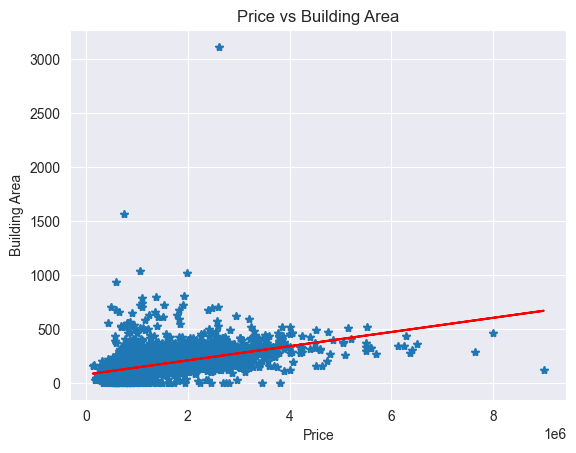

In [40]:
# Draw graph of correlation between Price and Building Area

## Converting the data in the columns to numeric 
housing_data[['Price', 'BuildingArea']] = housing_data[['Price', 'BuildingArea']].apply(pd.to_numeric)

## Reshaping the data to a 2D array in order to plot it in the Linear Regression 
price = housing_data['Price'].values.reshape(-1,1)
building_area = housing_data['BuildingArea'].values.reshape(-1,1)

## Creating a Linear Regression model to predict the data for Building Area based on the Price
reg = LinearRegression().fit(price, building_area)

## Functions to plot the graph
plt.plot(housing_data[['Price']], housing_data[['BuildingArea']], '*')
plt.plot(housing_data[['Price']], reg.predict(price), 'r')

## Adding labels to the graph
plt.xlabel('Price')
plt.ylabel('Building Area')
plt.title('Price vs Building Area')
plt.show()

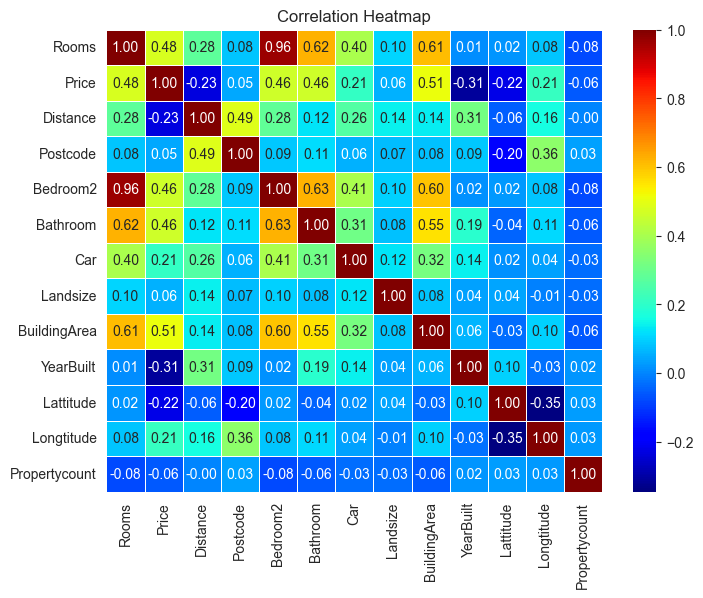

In [41]:
# Code from sample Assignment 1 provided by the lecturer

# Dataframe of key attributes
housing_data.corr()

# Correlation matrix
corr_matrix = housing_data.corr()

# Generate Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='jet', cbar=True, fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [42]:
# # 1. The Data Set 
#   (b). Pre-Processing - Normalisation

# Normalizing the data
scaler = MinMaxScaler()
housing_data[['Rooms', 'Price', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Propertycount']] = scaler.fit_transform(housing_data[['Rooms', 'Price', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Propertycount']])

# Dropping Postcode, Landsize and Propertycount as the values are very close to 0
# Also dropping Longitude and Langitude columns as they're useless for correlating price as we already have a Distance (to CBD) column

housing_data.drop(["Postcode", "Landsize", "Propertycount", "Longtitude", "Lattitude"], inplace=True, axis="columns")

# Since we dropped alot of rows previously due to NaN values and Unnecessary data, the rows index stayed the same
# So we now need to reset the index back to normal to avoid confusion and keep them in order
housing_data = housing_data.reset_index(drop=True)

housing_data.head()

,Rooms,Price,Distance,Bedroom2,Bathroom,Car,BuildingArea,YearBuilt
0,0.090909,0.101928,0.052743,0.166667,0.000,0.0,0.025386,0.855407
1,0.181818,0.150412,0.052743,0.250000,0.125,0.0,0.048201,0.855407
2,0.272727,0.165633,0.052743,0.250000,0.000,0.2,0.045630,0.993925
3,0.181818,0.196753,0.052743,0.333333,0.125,0.0,0.067481,0.867558
4,0.090909,0.169692,0.052743,0.166667,0.000,0.2,0.034383,0.843256


In [43]:
rows = len(housing_data.axes[0])
columns = len(housing_data.axes[1])

print("Number of columns: ", columns)
print("Number of rows: ", rows)

Number of columns:  8
Number of rows:  17774


In [44]:
# Correlating the price of each property based on it's features, so the model can predict the price of a property based on it's features
features = ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'BuildingArea','YearBuilt']

x = housing_data[features]
y = housing_data['Price']

# Dividing the price column into 5 sections (labels) in order to classify correctly and can be used in the output layer of our model

# label 0 = 0.00 to 0.15 (first section)
# label 1 = 0.15 to 0.38 (second section)
# label 2 = 0.38 to 0.62 (third section)
# label 3 = 0.62 to 0.85 (fourth section)
# label 4 = 0.85 to 1.00 (last section)

y = pd.cut(y, bins=[0.00, 0.15, 0.38, 0.62, 0.85, 1.00], labels=[0, 1, 2, 3, 4])
print(y)

# In order to validate and evaluate the model, we are splitting the dataset into two parts, training and testing data
# x_train = the training data, which the model will be using to train, this is usualy a higher percentage of the dataset being around 70-80%
# x_test = the testing data, the remainder of the dataset not used by x_train is going to be used fot testing it
# y_train = this is the target labels for the training data, the model will use this to learn the relationship between the features and the labels
# y_test = testing labels, 
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

# Printing the shape of the training and testing data, to verify the split and copare and test it later on      we can delete this later
print("\nx_train shape: ", x_train.shape[0])
print("x_test shape: ", x_test.shape[0])

0        0
1        1
2        1
3        1
4        1
        ..
17769    0
17770    0
17771    0
17772    0
17773    0
Name: Price, Length: 17774, dtype: category
Categories (5, int64): [0 < 1 < 2 < 3 < 4]

x_train shape:  13330
x_test shape:  4444


In [45]:
# 2. Hyperparameter
EPOCHS = 100 # amount of times the model will be trained on the dataset, pr the amount of times the model will go through the dataset. The more epochs, the more the model will learn
BATCH_SIZE = 128 # number of samples that will be used to train the model at once. This will affect how accurate the model will be, for example, if this value is too high it will not be as accurate as it could be if it is lower
LEARNING_RATE = 0.01 # learning rate that the optimiser will use to update the weights of the model
VERBOSE = 1 # this is for how the information is displayed in the console when training the model
VALIDATION_SPLIT = 0.2 # in the same way the data was splitted for training and testing, here we split it for validation and evaluate the model during training, this is to prevent overfitting
NB_CLASSES = 5 # number of outputs, in our case this is the amount of labels that we are categorising the data (price) into
N_HIDDEN = 24 # number of neurons in the hidden layer, this affects the capacity of the model to learn the data, too many neurons can cause overfitting and too few can cause underfitting
LOSS = 'categorical_crossentropy' # loss function used to calculate the error of the model

# One hot representation of the samples (Lab3 - Exercise 2)
y_train = tf.keras.utils.to_categorical(y_train, NB_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, NB_CLASSES)

# Defining model
model = tf.keras.models.Sequential()

# Add layers to the model
model.add(tf.keras.layers.Dense(N_HIDDEN, input_shape=(len(features),), name='dense-layer', activation='relu'))

# Softmax classification - Converts the output for each class to a probability value between 0-1, which is exponentially normalized among the classes. 
model.add(tf.keras.layers.Dense(NB_CLASSES, activation='softmax'))

# 3. Adaptive Moment Estimation (Adam) optimiser:
# We chose this optimiser because of its adaptive learning rates and optimization efficiency. 
# It also applies bias correction during the early iterations of training, ensuring faster convergence and a stable training process.
optimiser = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# Compile the model with categorical_crossentropy loss function, we are using this function
# because it computes the loss between the labels (the price labels we have previously classified) and predictions
model.compile(optimizer=optimiser, loss=LOSS, metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense-layer (Dense)             │ (None, 24)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 317 (1.24 KB)

 Trainable params: 317 (1.24 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7992 - loss: 0.7496 - val_accuracy: 0.8151 - val_loss: 0.4104
Epoch 2/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - accuracy: 0.8391 - loss: 0.4039 - val_accuracy: 0.8421 - val_loss: 0.3764
Epoch 3/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - accuracy: 0.8479 - loss: 0.3733 - val_accuracy: 0.8485 - val_loss: 0.3678
Epoch 4/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - accuracy: 0.8438 - loss: 0.3826 - val_accuracy: 0.8436 - val_loss: 0.3603
Epoch 5/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - accuracy: 0.8394 - loss: 0.3797 - val_accuracy: 0.8436 - val_loss: 0.3565
Epoch 6/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - accuracy: 0.8467 - loss: 0.3654 - val_accuracy: 0.8428 - val_loss: 0.3621
Epoch 7/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step - accuracy: 0.8458 - loss: 0.3680 - val_accuracy: 0.8473 - val_loss: 0.3480
Epoch 8/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - accuracy: 0.8479 - loss: 0.3606 - val_accura

In [46]:
# Evaluating the model
print("Evaluate model")
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("\nTest accuracy: %.4f" % test_accuracy)
print("Test loss: %.4f" % test_loss)

Evaluate model
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 249us/step - accuracy: 0.8727 - loss: 0.3176

Test accuracy: 0.8708
Test loss: 0.3195


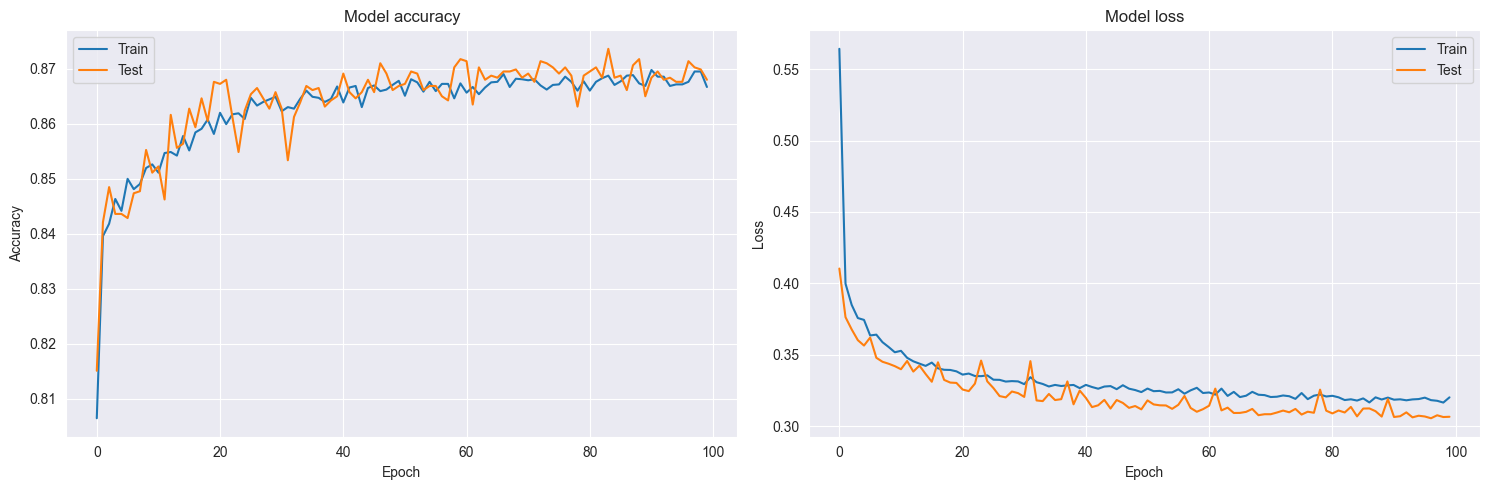

In [47]:
# Plotting graphs on the model's accuracy and loss

# Here we are plotting two graphs:
#   One is for the accuracy of teh training and testing, which will show us how well the model is learning the data
#   The other is for the loss between training and testing, showing us how well the model is predicting the data

# Accuracy Graph
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Loss Graph
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

# Display both graphs
plt.tight_layout()
plt.show()

In [48]:
# 4. Cross fold validation
# Code from sample Assignment 1 provided by the lecturer.
print(f"\nCross Fold Validation")

# The cv variable will determine the cross validation splitting strategy. In this case we are using KFold with 5 splits
# We are also randomising the data, so that it is different every time the code runs
cv = KFold(n_splits=5, shuffle=True, random_state=1)
# We created a KerasClassifier object using our previously created model, because our original model was causing errors with the cross_val_score function
keras_clf = KerasClassifier(model=model, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)
# here we are doing the cross validation using the keras_clf and using the x_train and y_train data
scores = cross_val_score(keras_clf, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))


Cross Fold Validation
Accuracy: 0.868 (0.004)


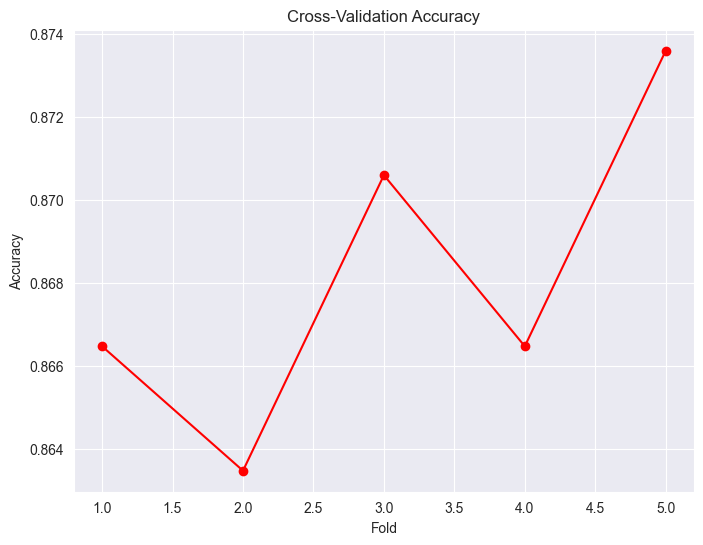

In [49]:
# Code from sample Assignment 1 provided by the lecturer.
# Plotting the cross-validation accuracy

# Here we are plotting the accuracy of the cross validation, 
# this will help us to evaluate the model and see how well it is performing
# showing the accuracy of the model in each fold

plt.figure(figsize=(8, 6))

plt.plot(range(1, 6), scores, marker='o', linestyle='-', color='red')
plt.title('Cross-Validation Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()